In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# Image directory
dir_image = '/content/gdrive/My Drive/Colab Notebooks/딥러닝과제1'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
# Parameters
train_buf = 60000
test_buf = 10000 
batch_size = 32
learning_rate = 1e-3
training_epochs = 30
display_step = 10

In [15]:
apply_approx = 0

In [16]:
# Load and prepare the MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(y_train, x_train), (y_test, x_test) = fashion_mnist.load_data()

# Reshape datasets
y_train = y_train.reshape(y_train.shape[0], 28, 28, 1).astype("float32") / 255.0
y_test = y_test.reshape(y_test.shape[0], 28, 28, 1).astype("float32") / 255.0

x_train = tf.reshape(tf.one_hot(x_train, 10), (-1, 10))
x_test = tf.reshape(tf.one_hot(x_test, 10), (-1, 10))

# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(train_buf)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .shuffle(test_buf)
    .batch(batch_size)
)

In [17]:
dim_x = np.shape(x_train)[1:]
dim_y = np.shape(y_train)[1:]
print(dim_x)
print(dim_y)

(10,)
(28, 28, 1)


In [18]:
class CVAE(keras.Model):
  """ A basic cvae class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(CVAE, self).__init__()
    self.__dict__.update(kwargs)

    self.dim_y_prod = reduce( (lambda x, y: x * y), self.dim_y)

    # Set network
    # q(z|x,y)
    self.enc_xy_x_nn = keras.Sequential(self.enc_xy_desc[0])
    self.enc_xy_y_nn = keras.Sequential(self.enc_xy_desc[1])
    self.enc_xy_concat_nn = keras.Sequential(self.enc_xy_desc[2])

    # p(z|x)
    if self.apply_approx == 0:
      self.enc_x_nn = keras.Sequential(self.enc_x_desc)

    # p(y|x,z)
    self.dec_xz_nn = keras.Sequential(self.dec_xz_desc)

  def encode_xy(self, x, y):
    enc_xy_x = self.enc_xy_x_nn(x)
    enc_xy_y = self.enc_xy_y_nn(y)
    enc_xy_concat = tf.concat([enc_xy_x, enc_xy_y], axis=1)
    enc_xy = self.enc_xy_concat_nn(enc_xy_concat)

    mu, log_sigma = tf.split(enc_xy, num_or_size_splits=2, axis=1)
    # sigma = keras.backend.exp(log_sigma)
    sigma = keras.backend.softplus(log_sigma)
    return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

  def encode_x(self, x):
    if self.apply_approx == 0:
      mu, log_sigma = tf.split(self.enc_x_nn(x), num_or_size_splits=2, axis=1)
      sigma = keras.backend.softplus(log_sigma)
      p_z = ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    else:
      p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
    return p_z

  def decode(self, x, z):
    xz_concat = tf.concat([x, z], axis=1)
    return self.dec_xz_nn(xz_concat)

  def reconstruct(self, x):
    if self.apply_approx == 0:
      mu, _ = tf.split(self.enc_x_nn(x), num_or_size_splits=2, axis=1)
    else:
      mu = [0.] * z.shape[-1]
    
    return self.decode(x, mu)

  @tf.function
  def compute_loss(self, x, y):
    q_z = self.encode_xy(x, y)
    z = q_z.sample()
    y_recon = self.decode(x, z)

    # Compute KL-divergence
    p_z = self.encode_x(x)
    kl_div = ds.kl_divergence(q_z, p_z)
    loss_latent = tf.reduce_mean(tf.maximum(kl_div, 0))

    # Compute reconstruction loss
    y_r = keras.backend.reshape(y, [-1, self.dim_y_prod])
    y_recon_r = keras.backend.reshape(y_recon, [-1, self.dim_y_prod])
    if self.loss_type == "l2":
      diffsq_y = tf.math.square(y_r - y_recon_r)
      _loss_recon = tf.reduce_sum(diffsq_y, axis=-1, keepdims=True)
    else:
      _tmp0 = y_r*keras.backend.log(y_recon_r + 1e-6)
      _tmp1 = (1-y_r)*keras.backend.log(1 - y_recon_r + 1e-6)
      bce = -(_tmp0 + _tmp1)
      _loss_recon = tf.reduce_sum(bce, axis=-1, keepdims=True)
    loss_recon = tf.reduce_mean(_loss_recon)

    return loss_latent, loss_recon

  def get_trainable_vars(self):
    trainable_vars = self.enc_xy_x_nn.trainable_variables +\
      self.enc_xy_y_nn.trainable_variables + \
      self.enc_xy_concat_nn.trainable_variables + \
      self.dec_xz_nn.trainable_variables

    if self.apply_approx == 0:
      trainable_vars = trainable_vars + self.enc_x_nn.trainable_variables
    
    return trainable_vars

  def compute_gradients(self, x, y):
    with tf.GradientTape() as tape:
        loss_latent, loss_recon = self.compute_loss(x, y)
        loss_sum = loss_latent + loss_recon

    cg = tape.gradient(loss_sum, self.get_trainable_vars())
    return cg, loss_latent, loss_recon
  
  @tf.function
  def train(self, x, y):
    """ Trains model. """
    cg, loss_latent, loss_recon = self.compute_gradients(x, y)
    self.optimizer.apply_gradients(zip(cg, self.get_trainable_vars()))
    return loss_latent, loss_recon

In [19]:
dim_z = 2

dim_enc_xy_x = 32
dim_enc_xy_y = 64

# q(z|x,y)
enc_xy_x_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
                 keras.layers.Dense(units=dim_enc_xy_x, activation="relu")]

enc_xy_y_desc = [keras.layers.InputLayer(input_shape=dim_y, dtype=tf.float32),
                 keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
                 keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
                 keras.layers.Flatten(),
                 keras.layers.Dense(units=dim_enc_xy_y, activation="relu")]

enc_xy_concat_desc = [keras.layers.InputLayer(input_shape=dim_enc_xy_x + dim_enc_xy_y, dtype=tf.float32),
                      keras.layers.Dense(units=2*dim_z)]

enc_xy_desc = [enc_xy_x_desc, enc_xy_y_desc, enc_xy_concat_desc]

# p(z|x)
enc_x_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
              keras.layers.Dense(units=128, activation="relu"),
              keras.layers.Dense(units=2*dim_z)]

# p(y|x,z)
dec_xz_desc = [keras.layers.InputLayer(input_shape=dim_x[0] + dim_z, dtype=tf.float32),
               keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
               keras.layers.Reshape(target_shape=(7, 7, 64)),
               keras.layers.Conv2DTranspose(
                   filters=64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
               keras.layers.Conv2DTranspose(
                   filters=32, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
               keras.layers.Conv2DTranspose(
                   filters=1, kernel_size=3, strides=(1, 1), padding="same", activation="sigmoid")
               ]

# Set loss_type ("l2": l2-loss or "ce": cross-entropy)
loss_type = "ce"

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [20]:
cvae = CVAE(dim_y=dim_y, enc_xy_desc=enc_xy_desc, enc_x_desc=enc_x_desc,
            dec_xz_desc=dec_xz_desc, apply_approx=apply_approx, 
            loss_type=loss_type, optimizer=optimizer)

In [21]:
# Test-data for plot
test_data_x_plot, test_data_y_plot = next(iter(test_data))

import matplotlib.pyplot as plt

def plot_train(model, x, y, nex=6, zm=2, epoch=0):
  y_recon = model.reconstruct(x)

  q_z = model.encode_x(x)
  z = q_z.sample()
  y_sample = model.decode(x, z)

  fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
  
  is_first_row = 1
  for axi, (dat, lab) in enumerate(zip([x, y, y_recon, y_sample],
                                       ["label", "data", "data_recon", "data_sample"],)):
    
    if is_first_row:
      _x_plot = dat[0:nex, :]
      x_plot = np.argmax(_x_plot, axis=1)
      is_first_row = 0
      continue

    for ex in range(nex):
      axs[axi-1, ex].matshow(
          dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
          )
      axs[axi-1, ex].axes.get_xaxis().set_ticks([])
      axs[axi-1, ex].axes.get_yaxis().set_ticks([])
      axs[axi-1, 0].set_ylabel(lab)
      axs[axi-1, ex].set_xlabel(x_plot[ex])
      
  plt.show()
  
  # Save fig
  figname2save = '{:s}/cvae_z{:d}_{:s}_a{:d}_e{:d}.png'.format(
      dir_image,dim_z,loss_type,apply_approx,epoch)
  fig.savefig(figname2save)

  # Close fig
  plt.close()

In [22]:
# Select metrics to measure the loss of the model
train_loss_latent = keras.metrics.Mean(name='train_loss_latent')
train_loss_recon = keras.metrics.Mean(name='train_loss_recon')
test_loss_latent = keras.metrics.Mean(name='train_loss_latent')
test_loss_recon = keras.metrics.Mean(name='train_loss_recon')

Epoch 1, Train-Loss: [3.9092,264.6087], Test-Loss: [4.5291,253.7078]


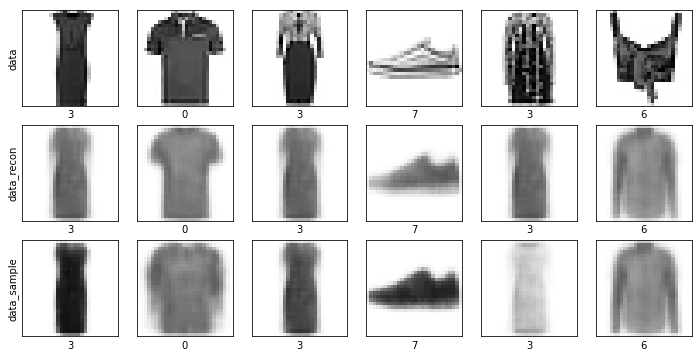

Epoch 2, Train-Loss: [4.3063,250.9406], Test-Loss: [4.3684,251.6011]
Epoch 3, Train-Loss: [4.3788,249.4410], Test-Loss: [4.4287,250.4549]
Epoch 4, Train-Loss: [4.4267,248.5865], Test-Loss: [4.4452,250.0161]
Epoch 5, Train-Loss: [4.4703,248.0448], Test-Loss: [4.5537,250.1180]
Epoch 6, Train-Loss: [4.4878,247.5678], Test-Loss: [4.3850,249.0734]
Epoch 7, Train-Loss: [4.5223,247.1852], Test-Loss: [4.6555,249.0697]
Epoch 8, Train-Loss: [4.5363,246.8698], Test-Loss: [4.5476,248.8067]
Epoch 9, Train-Loss: [4.5751,246.6076], Test-Loss: [4.6259,248.1615]
Epoch 10, Train-Loss: [4.5878,246.3638], Test-Loss: [4.5358,248.4062]
Epoch 11, Train-Loss: [4.5992,246.1253], Test-Loss: [4.6680,247.9601]


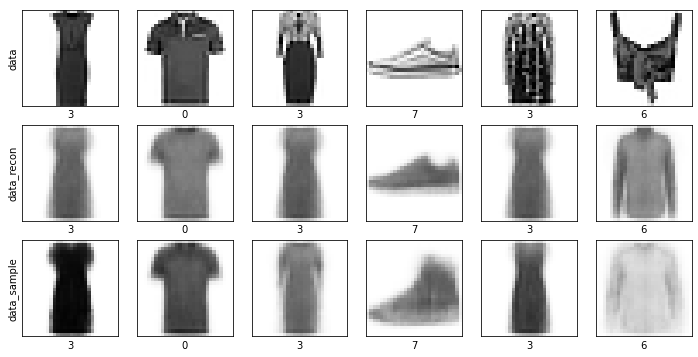

Epoch 12, Train-Loss: [4.6235,245.9297], Test-Loss: [4.6756,247.5657]
Epoch 13, Train-Loss: [4.6432,245.7715], Test-Loss: [4.5985,247.9319]
Epoch 14, Train-Loss: [4.6595,245.5697], Test-Loss: [4.7478,247.4338]
Epoch 15, Train-Loss: [4.6680,245.4261], Test-Loss: [4.6453,247.4617]
Epoch 16, Train-Loss: [4.6851,245.2864], Test-Loss: [4.6120,247.7619]
Epoch 17, Train-Loss: [4.6920,245.1207], Test-Loss: [4.6549,247.1087]
Epoch 18, Train-Loss: [4.7056,244.9754], Test-Loss: [4.6043,247.3831]
Epoch 19, Train-Loss: [4.7136,244.8707], Test-Loss: [4.8063,247.2273]
Epoch 20, Train-Loss: [4.7314,244.8107], Test-Loss: [4.5944,247.5174]
Epoch 21, Train-Loss: [4.7444,244.6608], Test-Loss: [4.8173,246.9569]


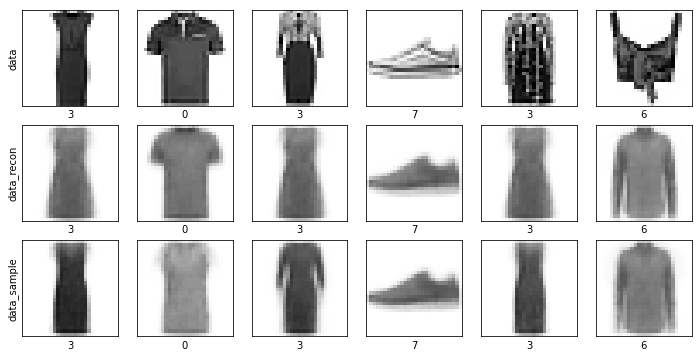

Epoch 22, Train-Loss: [4.7713,244.5198], Test-Loss: [4.7863,246.9834]
Epoch 23, Train-Loss: [4.7731,244.4333], Test-Loss: [4.8850,247.0541]
Epoch 24, Train-Loss: [4.7812,244.3268], Test-Loss: [4.5692,247.0137]
Epoch 25, Train-Loss: [4.7903,244.2389], Test-Loss: [4.5725,247.0415]
Epoch 26, Train-Loss: [4.8113,244.1231], Test-Loss: [4.8091,246.5708]
Epoch 27, Train-Loss: [4.7970,244.0535], Test-Loss: [4.7436,246.7079]
Epoch 28, Train-Loss: [4.8098,243.9752], Test-Loss: [4.6640,246.6429]
Epoch 29, Train-Loss: [4.8234,243.8801], Test-Loss: [4.8935,246.4282]
Epoch 30, Train-Loss: [4.8339,243.8315], Test-Loss: [4.8076,246.8504]


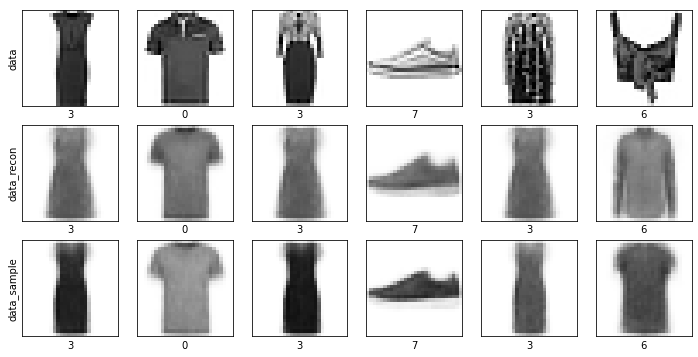

In [23]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch, y_batch in train_data:
    loss_latent, loss_recon = cvae.train(x_batch, y_batch)
    train_loss_latent(loss_latent)
    train_loss_recon(loss_recon)

  for x_batch_t, y_batch_t in test_data:
    loss_latent_t, loss_recon_t = cvae.compute_loss(x_batch_t, y_batch_t)
    test_loss_latent(loss_latent_t)
    test_loss_recon(loss_recon_t)

  template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(template.format(epoch+1, train_loss_latent.result(),
                        train_loss_recon.result(), test_loss_latent.result(),
                        test_loss_recon.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_train(cvae, test_data_x_plot, test_data_y_plot, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_loss_latent.reset_states()
  train_loss_recon.reset_states()
  test_loss_latent.reset_states()
  test_loss_recon.reset_states()

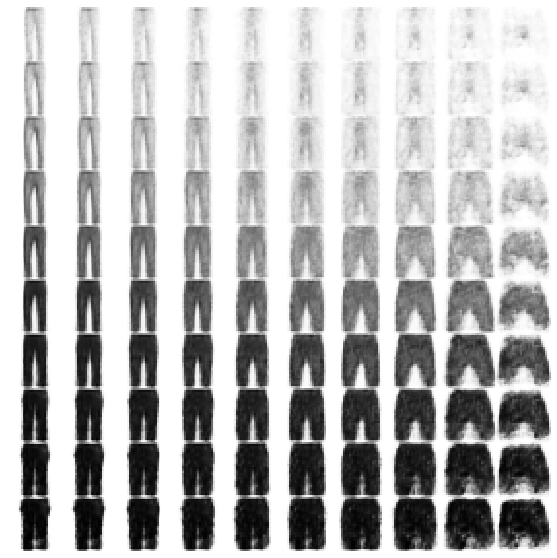

In [24]:
# Sample from grid
nx = ny = 10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_sel = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)
x_grid = np.tile(x_sel, (nx*ny, 1))
y_grid = cvae.decode(x_grid, meshgrid)
y_grid = y_grid.numpy().reshape(nx, ny, 28,28, 1)
# Fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = y_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

# Save fig
figname2save = '{:s}/cvae_z{:d}_{:s}_a{:d}_grid.png'.format(dir_image,dim_z,
                                                            loss_type, apply_approx)
fig.savefig(figname2save)